I had the pleasure of attending a [workshop](http://calcul.math.cnrs.fr/spip.php?article284) given by the [groupe calcul (CNRS)](http://calcul.math.cnrs.fr) this week. The topic was: how do you optimize the execution speed of your Python code, under the hypothesis that you already tried to make it fast using NumPy? 

The training was held over three days and presented three interesting ways to achieve speedups: [Cython](http://cython.readthedocs.io/en/latest/), [pythran](https://pythonhosted.org/pythran/) and [numba](http://numba.pydata.org).

Overall, the workshop was great. The goal of this blog post is to summarize some of the key insights that I learnt while using these three tools on an practical application: image filtering.

# Introducing the discrete Laplacian 

When working with images, the [discrete Laplacian operator](https://en.wikipedia.org/wiki/Discrete_Laplace_operator) is often used for edge detection.

Intuitively, if you want to find the edges of an image, you compute the Laplacian and threshold it to see the edges appear. Let's give an example using scikit-image. 

First, let's load a standard grayscale image that ships with scikit-image, the `astronaut`.

In [1]:
import skimage.data
import skimage.color

In [2]:
image = skimage.data.astronaut()
image = skimage.color.rgb2gray(image)
image.shape

(512, 512)

Now, let's write a function that uses the scikit-image implementation of the discrete Laplace operator and thresholds the result with a fixed threshold. 

In [3]:
from skimage.filters import laplace
import numpy as np

In [4]:
def laplace_skimage(image):
    """Applies Laplace operator to 2D image using skimage implementation. 
    Then tresholds the result and returns boolean image."""
    laplacian = laplace(image)
    thresh = np.abs(laplacian) > 0.05
    return thresh

Let's apply the function and check its result.

In [5]:
edges = laplace_skimage(image)

In [6]:
edges.shape

(512, 512)

Let's display the obtained edges, along with the original image.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def compare(left, right):
    """Compares two images, left and right."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(left, cmap='gray')
    ax[1].imshow(right, cmap='gray')

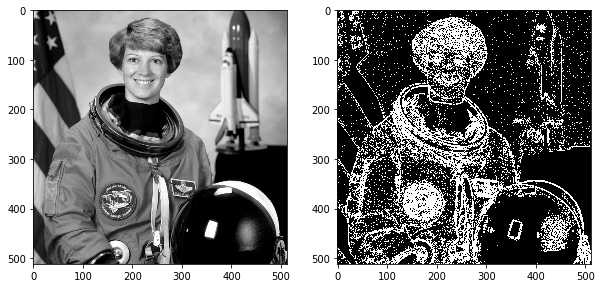

In [9]:
compare(left=image, right=edges)

Since the topic of this post is to deal with optimization, we will now suppose that we're not using scikit-image. 

As is usually the case when you're working on your own problems, we'll implement the Laplacian algorithm by ourselves using NumPy.

# NumPy implementation 

So here we go: we write a function that makes use of vectorized NumPy to perform the same operation than the scikit-image implementation. 

In [10]:
def laplace_numpy(image):
    """Applies Laplace operator to 2D image using our own NumPy implementation. 
    Then tresholds the result and returns boolean image."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

If you're paying attention closely, we're not actually implementing exactly the same function as scikit-image, since we're excluding all border pixels of the image from our calculation. 

Let's check the result is qualitatively correct.

In [11]:
laplace_numpy(image).shape

(510, 510)

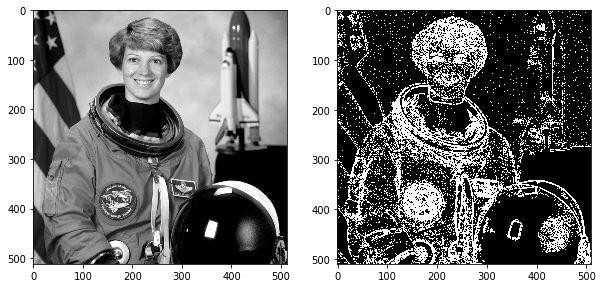

In [12]:
compare(image, laplace_numpy(image))

And let's also check that our implementation quantitavely agrees with scikit-image on every interior pixel.

In [13]:
np.allclose(laplace_skimage(image)[1:-1, 1:-1], laplace_numpy(image))

True

Good, we're now all set for the next step. Let's pretend that we think our implementation is slow. How do we objectively measure that? And then: how do we make it faster?

# Profiling and timing 

So, we think our NumPy version is slow. How can we put a number on that feeling? The first idea is to time the execution on our test image. We can easily do this with the `%time` line magic.

In [14]:
%time laplace_numpy(image)

CPU times: user 6.26 ms, sys: 2.47 ms, total: 8.73 ms
Wall time: 8.49 ms


array([[False,  True,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False]], dtype=bool)

Mmmh, around 5 milliseconds per call. If we run this multiple times, the results slightly vary.

Therefore, it is better to use the  `%timeit` line magic, which averages the timing operation and gives us a more accurate measurement.

In [15]:
%timeit laplace_numpy(image)

5.66 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


How does the scikit-image implementation compare to that?

In [16]:
%timeit laplace_skimage(image)

4.99 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Approximately the same, albeit a little slower. 

So, our function is too slow for say, our realtime application. To make it go faster, we first need to have an idea about what takes time in it.
Our function works in two steps: first we compute the laplacian and then we threshold the results. Which part of the function is taking the most time? 

To answer that question, we use a profiler. Many different profilers exit. We'll look at three below: %prun, %lprun and pprofile.

Using %prun gives us a high level view of what's happening inside our call.

In [17]:
r = %prun -r laplace_numpy(image)
r.print_stats()

          4 function calls in 0.007 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.007    0.007    0.007    0.007 <ipython-input-10-d2caf1f24bf1>:1(laplace_numpy)
        1    0.001    0.001    0.007    0.007 <string>:1(<module>)
        1    0.000    0.000    0.007    0.007 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




This is not very informative. But we understand that most of the time (column tottime) is spent inside our laplace_numpy function.

What about %lprun?

In [18]:
%load_ext line_profiler

In [19]:
r = %lprun -r -f laplace_numpy laplace_numpy(image)
r.print_stats()

Timer unit: 1e-06 s

Total time: 0.005994 s
File: <ipython-input-10-d2caf1f24bf1>
Function: laplace_numpy at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def laplace_numpy(image):
     2                                               """Applies Laplace operator to 2D image using our own NumPy implementation. 
     3                                               Then tresholds the result and returns boolean image."""
     4         1         4757   4757.0     79.4      laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
     5         1         1236   1236.0     20.6      thresh = np.abs(laplacian) > 0.05
     6         1            1      1.0      0.0      return thresh



Running `%lprun -r -f laplace_numpy laplace_numpy(image)` means that we aske %lprun to show how long each line took to execute inside the function `laplace_numpy` and return the result as an object.

Here, we can answer the earlier question: computing the laplacian is what takes the most time in this function.

Let's see if [`pprofile`](https://github.com/vpelletier/pprofile) confirms that measurement.

In [20]:
import pprofile
def func_to_profile():
    prof = pprofile.Profile()
    with prof():
        laplace_numpy(image)
    prof.print_stats()

In [21]:
func_to_profile()

Total duration: 0.00623107s
File: <ipython-input-10-d2caf1f24bf1>
File duration: 0.00590301s (94.74%)
Line #|      Hits|         Time| Time per hit|      %|Source code
------+----------+-------------+-------------+-------+-----------
     1|         1|  2.59876e-05|  2.59876e-05|  0.42%|def laplace_numpy(image):
     2|         0|            0|            0|  0.00%|    """Applies Laplace operator to 2D image using our own NumPy implementation.
     3|         0|            0|            0|  0.00%|    Then tresholds the result and returns boolean image."""
     4|         1|   0.00461984|   0.00461984| 74.14%|    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
     5|         1|   0.00123024|   0.00123024| 19.74%|    thresh = np.abs(laplacian) > 0.05
(call)|         1|   0.00590301|   0.00590301| 94.74%|# <ipython-input-10-d2caf1f24bf1>:1 laplace_numpy
     6|         1|  2.69413e-05|  2.69413e-05|  0.43%|    return thresh


/Users/kappamaki/anaconda/lib/python3.6/site-packages/pprofile.py:102: UserWarning: Cannot access "<ipykernel.iostream.OutStream object at 0x109f8f860>.buffer", invalid entities from source files will cause errors when annotating.
  'files will cause errors when annotating.' % (stream, )


pprofile confirms the previous assessment: it's the laplacian computation that takes time. 

What's more, pprofile is a little bit simpler to use than line_profiler. However, it doesn't feature a cell magic (although there's already someone asking for this [here](https://github.com/vpelletier/pprofile/issues/21)).

At this point, we know that to make our function faster, the first thing to optimize is the computation of the laplacian. Let's try that using Cython.

# Cython 

What Cython does, like the other tools we'll see below, is to compile our Python code into C code that will hopefully be very fast. 
Since Cython has a so-called IPython magic function, we'll be able to continue working in the notebook. 
If we use the `-a` option with the Cython magic, we can obtain an annotated version of our source code that shows where Cython uses C code and where it uses Python objects.

In [22]:
%load_ext cython

In [23]:
%%cython -a
import numpy as np
   
def laplace_cython(image):
    """Applies Laplace operator to 2D image, then tresholds the result and returns boolean image.
    Cython implementation."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

What the above code shows is that Cython couldn't optimize our function much, as indicated by the yellow hue of the lines above. The yellow intensity in each line shows the amount of interaction with Python objects that it found. The more you have to use Python objects, the less speedup you are likely to achieve. 

Let's time this first compiled version.

In [24]:
%timeit laplace_cython(image)

4.49 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It performs roughly at the same speed that our NumPy version. So there's no much use in switching to Cython. Can we do better? The key is to eliminate interaction with Python through different ways. A first one is to declare our input image is an array.

In [25]:
%%cython -a
import numpy as np
cimport numpy as cnp

def laplace_cython(cnp.ndarray image):
    """Applies Laplace operator to 2D image, then tresholds the result and returns boolean image.
    Cython implementation."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [26]:
%timeit laplace_cython(image)

3.93 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The timing didn't improve. It turns, if you click on the yellow lines, that Cython is not able to optimize the broadcasting operation (and its fancy bracketing) that we usually perform with NumPy. To allow Cython to optimize, let's write an explicit loop over the pixels in the image.

In [27]:
%%cython -a
import numpy as np
cimport numpy as cnp

def laplace_cython(cnp.ndarray image):
    """Applies Laplace operator to 2D image, then tresholds the result and returns boolean image.
    Cython implementation."""
    cdef int h = image.shape[0]
    cdef int w = image.shape[1]
    laplacian = np.empty((w-2, h-2))
    cdef int i, j
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [28]:
%timeit laplace_cython(image)

333 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Woops! The function we just wrote is 100x times slower than our NumPy implementation! The reason can be traced to the core of our function: the sum of the five pixel bound terms should be free from any Python object conversions. However, that line is all yellow and if you click it, you'll see it's full of Python object conversions. 

How do we solve this problem? The answer is: we need to pass the array as a buffer that can be accessed at C speeds. Let's see:

In [29]:
%%cython -a
import numpy as np
cimport numpy as cnp

def laplace_cython(cnp.ndarray[double, ndim=2] image):
    """Applies Laplace operator to 2D image, then tresholds the result and returns boolean image.
    Cython implementation."""
    cdef int h = image.shape[0]
    cdef int w = image.shape[1]
    cdef cnp.ndarray[double, ndim=2] laplacian = np.empty((w-2, h-2), dtype=np.double)
    cdef int i, j
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [30]:
%timeit laplace_cython(image)

2.57 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally! We have made our function faster by a factor of 2.

But can we go further? Yes, by observing that on the summation line, Cython still performs some bounds checks.

In [31]:
%%cython -a
import numpy as np
cimport numpy as cnp
import cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def laplace_cython(cnp.ndarray[double, ndim=2] image):
    """Applies Laplace operator to 2D image, then tresholds the result and returns boolean image.
    Cython implementation."""
    cdef int h = image.shape[0]
    cdef int w = image.shape[1]
    cdef cnp.ndarray[double, ndim=2] laplacian = np.empty((w-2, h-2), dtype=np.double)
    cdef int i, j
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [32]:
%timeit laplace_cython(image)

1.61 ms ± 96.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
np.allclose(laplace_numpy(image), laplace_cython(image))

True

What we can notice in the above function is that we have gotten rid completely of interaction in the for loop, which leads to a 4x increase in performance over our NumPy implementation.

Let's now turn to pythran.

# Pythran 

One of the advantages of pythran is that it can optimize higher level numpy code than Cython. Luckily for us again, it features a line magic, so we keep working in the notebook.

In [34]:
%load_ext pythran.magic

To use pythran, all you have to do is to annotate the function you want to export and give it a signature. This is done in a comment line starting the pythran file. One of the promises of pythran is that it can often handle high level broadcasting with NumPy and still optimize our function.

Annotating our NumPy function, we obtain this:

In [35]:
%%pythran
#pythran export laplace_pythran(float[][])
import numpy as np
def laplace_pythran(image):
    """Laplace operator in NumPy for 2D images. Pythran accelerated."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [36]:
np.allclose(laplace_numpy(image), laplace_pythran(image))

True

In [37]:
%timeit laplace_pythran(image)

40.3 ms ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In this case, it's disappointing. The pythran translated function is 10x times slower than pure NumPy.

But pythran can also translate "low level style" code, just like Cython. Let's try again.

In [38]:
%%pythran 
#pythran export laplace_pythran(float[][])
import numpy as np
def laplace_pythran(image):
    """Laplace operator in NumPy for 2D images. Pythran accelerated."""
    h = image.shape[0]
    w = image.shape[1]
    laplacian = np.empty((h - 2, w - 2))
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            laplacian[i-1, j-1] = image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [39]:
np.allclose(laplace_numpy(image), laplace_pythran(image))

True

In [40]:
%timeit laplace_pythran(image)

15.6 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Mmmh, still not very good. What if we move the thresholding operation inside the main loop?

In [41]:
%%pythran 
#pythran export laplace_pythran(float[][])
import numpy as np
def laplace_pythran(image):
    """Laplace operator in NumPy for 2D images. Pythran accelerated."""
    h = image.shape[0]
    w = image.shape[1]
    laplacian = np.empty((h - 2, w - 2))
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            laplacian[i-1, j-1] = np.abs(image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]) > 0.05
    return laplacian

In [42]:
np.allclose(laplace_numpy(image), laplace_pythran(image))

True

In [43]:
%timeit laplace_pythran(image)

1.29 ms ± 85.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So in this case, pythran with a low level approach outperforms Cython (barely).

Another interesting point here, concerning debugging pythran compilation, is that pythran annotated code is still perfectly valid Python. This helps during the debugging phase, compared to the previously explained Cython approach.

Let's turn to our last tool, `numba`.

# Numba 

Numba is very similar to pythran, except that it does just-in-time compilation (JIT). We have several options to for use. Let's try the standard `jit` approach with a decorator.

In [44]:
from numba import jit

In [45]:
@jit
def laplace_numba(image):
    """Laplace operator in NumPy for 2D images. Accelerated using numba."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

We call it once to avoid timing issues due to JIT compilation.

In [46]:
laplace_numba(image);

In [47]:
%timeit laplace_numba(image)

3.06 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is rightaway faster than NumPy.

We can also tell numba to avoid using Python at all in its computation. This is called with `@jit(nopython=True)`.

In [48]:
@jit(nopython=True)
def laplace_numba(image):
    """Laplace operator in NumPy for 2D images. Accelerated using numba."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [49]:
laplace_numba(image);

In [50]:
%timeit laplace_numba(image)

2.93 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


No big effect. In fact, we can infer from this that numba managed to generate pure C code from our function and that it did it already previously. 

To confirm that, we can either use the `inspect_types()` method of our jitted function or use the annotation tool provided with numba.

In [51]:
laplace_numba.inspect_types()

laplace_numba (array(float64, 2d, C),)
--------------------------------------------------------------------------------
# File: <ipython-input-48-eaa032c0e5bc>
# --- LINE 1 --- 
# label 0
#   del $const0.3
#   del $const0.2
#   del $0.4
#   del $const0.7
#   del $const0.6
#   del $0.8
#   del $0.9
#   del $0.5
#   del $0.10
#   del $const0.14
#   del $const0.13
#   del $0.15
#   del $const0.18
#   del $const0.17
#   del $0.19
#   del $0.20
#   del $0.16
#   del $0.21
#   del $const0.26
#   del $const0.25
#   del $0.27
#   del $const0.30
#   del $const0.29
#   del $0.31
#   del $0.32
#   del $0.28
#   del $0.33
#   del $const0.38
#   del $const0.37
#   del $0.39
#   del $const0.42
#   del $const0.41
#   del $0.43
#   del $0.44
#   del $0.40
#   del $0.45
#   del $const0.51
#   del $const0.50
#   del $0.52
#   del $const0.55
#   del $const0.54
#   del $0.56
#   del $0.57
#   del $0.53
#   del image
#   del $0.58
#   del $const0.48
#   del $0.11
#   del $0.22
#   del $0.34
#   del $0.46
#

Admittedly, not very helpful. Let's try the annotation tool.

In [52]:
%%file numba_annotation_demo.py
import numpy as np
import skimage.data
import skimage.color
from numba import jit

@jit(nopython=True)
def laplace_numba(image):
    """Laplace operator in NumPy for 2D images. Accelerated using numba."""
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

image = skimage.data.astronaut()
image = skimage.color.rgb2gray(image)
laplace_numba(image)

Overwriting numba_annotation_demo.py


We have to run the annotation tool from the command line:

In [53]:
!numba --annotate-html annotation.html numba_annotation_demo.py

In [54]:
from IPython.display import HTML

In [55]:
HTML(data=open('annotation.html').read())

6:,@jit(nopython=True)
,label 0
,del $const0.3
,del $const0.2
,del $0.4
,del $const0.7
,del $const0.6
,del $0.8
,del $0.9
,del $0.5
,del $0.10


What this shows is that `numba` managed to correctly optimize the broadcasting (if it hadn't we would have seen colored source code lines).

Let's see also investigate how numba optimizes the low-level approach with explicit for loops.

In [56]:
@jit(nopython=True)
def laplace_numba(image):
    """Laplace operator for 2D images. Numba accelerated."""
    h = image.shape[0]
    w = image.shape[1]
    laplacian = np.empty((h - 2, w - 2))
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            laplacian[i-1, j-1] = np.abs(image[i-1, j] + image[i+1, j] + image[i, j-1] + image[i, j+1] - 4*image[i, j]) > 0.05
    return laplacian

In [57]:
laplace_numba(image);

In [58]:
%timeit laplace_numba(image)

924 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This approach improves the performance! 

Another way of approaching optimization with numba is to thing in terms of NumPy ufuncs. You can write generalized ufuncs with numba using another decorator, `@guvectorize`. However, this comes at the cost that we have to think in terms of an ufunc and thus we have to provide an array that gets filled by our computation routine.

In [59]:
from numba import guvectorize

In [60]:
@guvectorize('void(float64[:, :], float64[:, :])', "(m, n)->(m, n)")
def laplace_numba_guvectorize(image, laplacian):
    """Laplace operator in NumPy for 2D images. Numba accelerated."""
    h = image.shape[0]
    w = image.shape[1]
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            laplacian[i-1, j-1] = np.abs(4 * image[i, j] - image[i - 1, j] - image[i + 1, j] - image[i, j + 1] - image[i, j - 1]) > 0.05

In [61]:
laplacian = np.empty_like(image)

In [62]:
laplace_numba_guvectorize(image, laplacian);

In [63]:
np.allclose(laplace_numpy(image), laplacian[:-2, :-2])

True

In [64]:
%timeit laplace_numba_guvectorize(image, laplacian);

609 µs ± 156 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This approach is even faster. However, it has some limitations: the signature for array sizes forces us to use the same shapes in the input and output. I could'nt use the  "(m, n)->(m-1, n-1)" signature. Note that we also could have target parallel execution by using the `target=parallel` option in the decorator.

# Wrap-up and plots 

Time for a wrap-up and some plots.

In [65]:
timings = {}
for func in [laplace_skimage, laplace_numpy, laplace_cython, laplace_pythran, laplace_numba]:
    t = %timeit -o func(image)
    timings[func.__name__] = t

4.61 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.38 ms ± 899 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.22 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.25 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
775 µs ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
t = %timeit -o laplace_numba_guvectorize(image, laplacian);
timings['laplace_numba_guvectorize'] = t

508 µs ± 5.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Here are the table and the plots.

In [67]:
import pandas as pd

In [68]:
pd.Series({key: timings[key].average * 1e6 for key in timings}).to_frame(name='timings (μs)').sort_values(by='timings (μs)')

,timings (μs)
laplace_numba_guvectorize,507.651230
laplace_numba,774.716209
laplace_pythran,1246.428633
laplace_cython,2219.494851
laplace_skimage,4611.953934
laplace_numpy,5383.624663


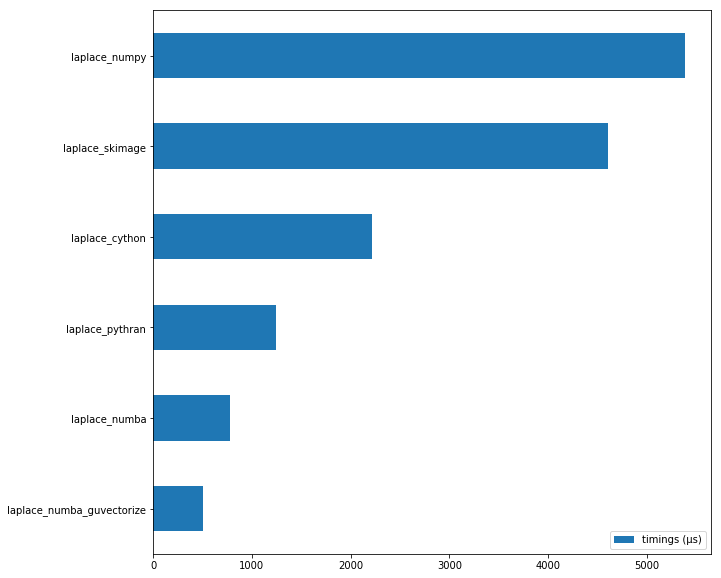

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
pd.Series({key: timings[key].average * 1e6 for key in timings}).to_frame(name='timings (μs)').sort_values(by='timings (μs)').plot(kind='barh', ax=ax)

**conclusions**


So, what have I learned during these last three days? Here are some thoughts:

- most approaches suggest you rewrite your function in a low-level style if you want a good optimization result
- most approaches rely on the type annotations which you supply and which are crucial for good results (and sometimes it's easy to forget one variable which in turn prevents the optimizer from doing its best)
- pythran, like numba, can in theory optimize high-level NumPy code (in our example, numba did better than pythran)
- numba yields the best performance in our benchmark
- Cython, contrary to what I expected, comes in after those two (but still yields a good speed-up)
- debugging all code generators is usually frustrating, due to difficult to understand error messages, low-level stuff (try reading the Cython output by clicking the yellow lines) 
- numba also allows targeting GPUs, something I haven't spoken about here since I don't have a GPU on my MacBook (this was the topic I had the most difficulty with during the training since I've never worked with GPUs)

**further reading**

- the resources that we used during the training can be found [here](http://calcul.math.cnrs.fr/spip.php?article284) (in French) - congratulations to the nice people who put in a lot of effort to organize the workshop: [Loïc Gouarin](https://www.math.u-psud.fr/~gouarin/), [Xavier Juvigny](https://www.researchgate.net/profile/Xavier_Juvigny), [Serge Guelton](http://serge.liyun.free.fr/serge/) and [Konrad Hinsen](http://khinsen.net) 
- there is a [great numba tutorial on YouTube](https://www.youtube.com/watch?v=SzBi3xdEF2Y) that was offered at SciPy 2016 (and that's going to get repeated at this years SciPy) by Lorena Barba and Gil Forsyth

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170706_OptimizingYourPythonCode.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170706_OptimizingYourPythonCode.ipynb).*